In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainingArguments
from sklearn.metrics import confusion_matrix

# Read the file


In [3]:



df1= pd.read_csv("/content/1429_1.csv")
df2 = pd.read_csv("/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
df3 = pd.read_csv("/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df4 = pd.read_csv("/content/All_Beauty (2).csv")



<ipython-input-3-68d3116372cc>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df1= pd.read_csv("/content/1429_1.csv")
<ipython-input-3-68d3116372cc>:4: DtypeWarning: Columns (9,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv("/content/All_Beauty (2).csv")



# Merge data while keeping all columns

In [4]:

combined_data = pd.concat([df1, df2, df3], ignore_index=True, join='outer')


print(combined_data.info())
print(combined_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    67992 non-null  object 
 1   name                  61232 non-null  object 
 2   asins                 67990 non-null  object 
 3   brand                 67992 non-null  object 
 4   categories            67992 non-null  object 
 5   keys                  67992 non-null  object 
 6   manufacturer          67992 non-null  object 
 7   reviews.date          67953 non-null  object 
 8   reviews.dateAdded     25091 non-null  object 
 9   reviews.dateSeen      67992 non-null  object 
 10  reviews.didPurchase   10 non-null     object 
 11  reviews.doRecommend   55152 non-null  object 
 12  reviews.id            71 non-null     float64
 13  reviews.numHelpful    55246 non-null  float64
 14  reviews.rating        67959 non-null  float64
 15  reviews.sourceURLs 

# Keep only the text and rating columns


In [5]:
combined_data = combined_data[['reviews.text', 'reviews.rating']]


print(combined_data.info())
print(combined_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    67991 non-null  object 
 1   reviews.rating  67959 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB
None
                                        reviews.text  reviews.rating
0  This product so far has not disappointed. My c...             5.0
1  great for beginner or experienced person. Boug...             5.0
2  Inexpensive tablet for him to use and learn on...             5.0
3  I've had my Fire HD 8 two weeks now and I love...             4.0
4  I bought this for my grand daughter when she c...             5.0


In [6]:
df4 = df4[['text', 'rating']]
print(df4.info())
print(df4.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759328 entries, 0 to 759327
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    759081 non-null  object 
 1   rating  759328 non-null  float64
dtypes: float64(1), object(1)
memory usage: 11.6+ MB
None
                                                text  rating
0  This spray is really nice. It smells really go...     5.0
1  This product does what I need it to do, I just...     4.0
2                          Smells good, feels great!     5.0
3                                     Felt synthetic     1.0
4                                            Love it     5.0


#Missing values

In [7]:
missing_values = combined_data.isnull().sum()

print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
reviews.text       1
reviews.rating    33
dtype: int64


In [8]:
missing_values = df4.isnull().sum()

print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
text    247
dtype: int64




#duplicates



In [9]:
combined_data = combined_data.drop_duplicates()

In [10]:
df4 = df4.drop_duplicates()

#
Text cleaning

In [11]:


def clean_text(text):
    if isinstance(text, float):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

combined_data['cleaned_review'] =combined_data['reviews.text'].apply(clean_text)


combined_data['sentiment'] = combined_data['reviews.rating'].apply(
    lambda x: 'Negative' if x in [1, 2] else ('Neutral' if x == 3 else 'Positive')
)


combined_data['label'] =combined_data['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})


print(combined_data[['cleaned_review', 'sentiment', 'label']])
df4['cleaned_review'] = df4['text'].apply(clean_text)
df4['sentiment'] = df4['rating'].apply(lambda x: 'Negative' if x in [1, 2] else ('Neutral' if x == 3 else 'Positive'))
df4['label'] = df4['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})
print(df4[['cleaned_review', 'sentiment', 'label']])

                                          cleaned_review sentiment  label
0      this product so far has not disappointed my ch...  Positive      2
1      great for beginner or experienced person bough...  Positive      2
2      inexpensive tablet for him to use and learn on...  Positive      2
3      ive had my fire hd 8 two weeks now and i love ...  Positive      2
4      i bought this for my grand daughter when she c...  Positive      2
...                                                  ...       ...    ...
65546  i bought the kindle when i was in the usa but ...  Positive      2
65547  i purchased my kindle2 in march of 09  and it ...  Negative      0
65548  can someone explain to me why i can find hundr...  Negative      0
66083  needed aninexpensive and portable alexa device...  Positive      2
66790  bought this tablet for my fiance daughter afte...  Positive      2

[47039 rows x 3 columns]
                                           cleaned_review sentiment  label
0       thi

# Extract reviews from data4

In [12]:
neutral_reviews = df4[df4['sentiment'] == 'Neutral']
negative_reviews = df4[df4['sentiment'] == 'Negative']
positive_reviews = combined_data[combined_data['sentiment'] == 'Positive']





# Balance categories with the highest number of positive reviews

In [13]:

max_positive_count = len(positive_reviews)


balanced_positive = positive_reviews.sample(n=max_positive_count, replace=True, random_state=42)
balanced_neutral = neutral_reviews.sample(n=max_positive_count, replace=True, random_state=42)
balanced_negative = negative_reviews.sample(n=max_positive_count, replace=True, random_state=42)


# Merge balanced reviews

In [14]:

balanced_data = pd.concat([balanced_positive, balanced_neutral, balanced_negative], ignore_index=True)



# Class distribution drawing


<ipython-input-15-bb051b908893>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=balanced_data, palette='viridis')


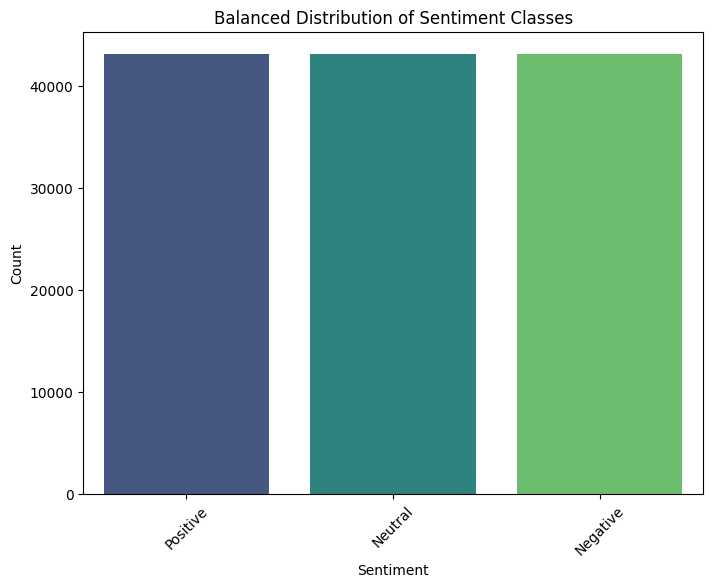

In [15]:

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=balanced_data, palette='viridis')
plt.title('Balanced Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [18]:
important_columns = ['sentiment', 'cleaned_review','label']

balanced_data= balanced_data[important_columns]

# Splitting data into features (X) and targets (y)

In [19]:
X = balanced_data['cleaned_review']
y = balanced_data['label']



# Splitting the data into a training and test set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 103507
Test set size: 25877


#
Download Tokenizer

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


#Encrypted data storage and classifications

In [22]:


class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Prepare data sets


In [23]:

train_dataset = ReviewDataset(train_encodings, y_train.tolist())
test_dataset = ReviewDataset(test_encodings, y_test.tolist())


# Download the BERT model

In [24]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



# Calculate the scales for each category

In [29]:
negative = 0
neutral = 1
positive = 2

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)



    return {
        'accuracy': accuracy,
        'precision_negative': precision[negative],
        'precision_neutral': precision[neutral],
        'precision_positive': precision[positive],
        'recall_negative': recall[negative],
        'recall_neutral': recall[neutral],
        'recall_positive': recall[positive],
        'f1_negative': f1[negative],
        'f1_neutral': f1[neutral],
        'f1_positive': f1[positive]
    }

# Training settings


In [26]:
training_args = TrainingArguments(
    output_dir='./results6',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,
    learning_rate=2e-5
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Create trainer

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)


In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Negative,Precision Neutral,Precision Positive,Recall Negative,Recall Neutral,Recall Positive,F1 Negative,F1 Neutral,F1 Positive
1,0.269200,0.325848,0.864126,0.804822,0.802180,0.983479,0.810836,0.793991,0.986194,0.807818,0.798065,0.984835
2,0.229100,0.323769,0.879275,0.846135,0.810029,0.980736,0.805231,0.841318,0.989876,0.825176,0.825377,0.985285
3,0.149800,0.369678,0.883410,0.843912,0.819034,0.986462,0.818192,0.841550,0.989185,0.830853,0.830139,0.987822
4,0.102500,0.444712,0.883526,0.840782,0.824751,0.982890,0.823797,0.834126,0.991371,0.832203,0.829412,0.987113
5,0.062400,0.515882,0.883487,0.843389,0.821372,0.984116,0.819360,0.838998,0.990796,0.831201,0.830091,0.987445


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=16175, training_loss=0.1666227218061916, metrics={'train_runtime': 937.6343, 'train_samples_per_second': 551.958, 'train_steps_per_second': 17.251, 'total_flos': 3.4536398767686144e+16, 'train_loss': 0.1666227218061916, 'epoch': 5.0})

# Evaluate the trained model using the validation set

In [31]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.4447120130062103, 'eval_accuracy': 0.8835259110406926, 'eval_precision_negative': 0.8407817900131093, 'eval_precision_neutral': 0.8247505447872463, 'eval_precision_positive': 0.9828903843960306, 'eval_recall_negative': 0.8237972909855208, 'eval_recall_neutral': 0.8341259714650272, 'eval_recall_positive': 0.9913713759779107, 'eval_f1_negative': 0.832202890002949, 'eval_f1_neutral': 0.8294117647058824, 'eval_f1_positive': 0.987112663955553, 'eval_runtime': 13.3865, 'eval_samples_per_second': 1933.061, 'eval_steps_per_second': 60.434, 'epoch': 5.0}


# Get forecasts

In [32]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Calculate the confusion matrix and plot the confusion matrix

Confusion Matrix:
 [[7055 1466   43]
 [1323 7191  107]
 [  13   62 8617]]


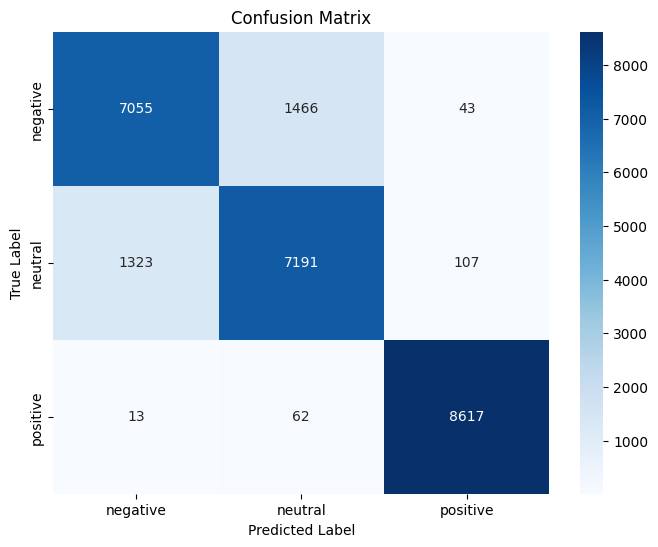

In [33]:
cm = confusion_matrix(true_labels, preds)

print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()